# Roman Urdu Sentiment Identification<br>

_Kyle Killion_ <br>

## BACKGROUND<br>
A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks
about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for
sentiment analysis, however, they need help with under-resourced languages.<br>
classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to
maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data
includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled. Please describe the business outcomes in your work sample including how data limitations impact your results
and how these limitations could be addressed in a larger project.

## Data Set Information:<br>
Tagged for Sentiment (Positive, Negative, Neutral)

## Attribute Information:<br>
Each record comprises of two string datatype values. One for Comment/Review and the second for sentiment.

## Relevant Papers:<br>

* Sharf, Zareen, and Saif Ur Rahman. â€œPerforming Natural Language Processing On Roman Urdu Datasets.' IJCSNS (January 2018 Volume) 
* Sharf, Zareen, and Saif Ur Rahman. 'Lexical normalization of roman Urdu text.' IJCSNS 17.12 (2017): 213. 

<span style="color:blue; font-family:Segoe UI Semibold">
    These were very informative papers over the foundations of the language and what issues you could find yourself running into. Lexical codification was an effort explained, in my mind, as scouring the internet for all combinations of a word and counting the most often deeming it the correct manner since there isn't a standardized format. This was helpful 70% of the time and found some failure cases where the standarization overlapped into other words. It was also mentioned that English words are also found sprinkled within the ecosystem of social media regarding Roman Urdu.
</span>

* Muhammad Arslan Manzoor, Saqib Mamoon, Song Kei Tao, Ali Zakir, Muhammad Adil, Jianfeng Lu<br>
    "Lexical Variation and Sentiment Analysis of Roman Urdu Sentences with Deep Neural Networks"<br>
    (IJACSA) International Journal of Advanced Computer Science and Applications,<br>
    Vol. 11, No. 2, 2020<br>
    https://thesai.org/Downloads/Volume11No2/Paper_90-Lexical_Variation_and_Sentiment_Analysis.pdf

<span style="color:blue; font-family:Segoe UI Semibold">
This paper as well goes into the complications of Roman Urdu and the need for standardization/normalization of the language.
</span>

_"The Roman script does not follow any standard which makes it more complicated than English language dataset. Different spelling refer to same word and identical spelling refer to different
contextual words. This phenomenon confuses the embedding of vocabulary and motivated us for normalization of Roman Urdu sentences. Previously, some approaches have been used
for normalization purposes to reduce the variation of embedding for the same word: Urdu phone, Similarity function, LexC clustering algorithm, Stemming and Lemmatizing [27], [28].
These approaches depend upon some rules and there is 30% to 40% chance of failure attributed to these rules. Making a set of similar words and clipping suffix or prefix can negatively influence the embedding behavior towards sentence polarity."_



## DATA<br>
Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set

In [57]:
import re
import pickle
import pandas as pd
from tqdm import tqdm
import numpy as np


from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 150

## Data Exploration - 

In [58]:
df = pd.read_csv(r'http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv', header=None)
df.columns = ['text', 'sent','mystery']
df = df.astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     20229 non-null  object
 1   sent     20229 non-null  object
 2   mystery  20229 non-null  object
dtypes: object(3)
memory usage: 474.2+ KB


In [59]:
df.head()

,text,sent,mystery
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,nan
1,sahi bt h,Positive,nan
2,"Kya bt hai,",Positive,nan
3,Wah je wah,Positive,nan
4,Are wha kaya bat hai,Positive,nan


## Mystery column will be ommited due to Attribute Information only mentioning Comment/Review and Sentiment

In [60]:
# Comes in Nan String instead of a real Nan Nan
df.mystery.replace('nan', np.nan, inplace=True)
df.dropna()

,text,sent,mystery
13637,movie abi b baki h,Neutral,----------------
13653,Hahahahahaha bilkul sahi,Neutral,----------
14218,tjhe ase mar na chahti hun tjhe nae tu achi b...,Negative,-------
14810,Yr tym pta chali kb ata raat m?,Positive,------
17161,Kya khatab g ledy type ka sahafi la k betha diya,Negative,9090
19499,kabhi bhai ki bhi aesi pic lele :P,Neutral,till here
19780,"Jahil awam ko jahil leader ki hi zroorat hai, ...",Negative,till here


In [61]:
del df['mystery']

## Fix the Neative to Negative

In [62]:
df['sent'] = df['sent'].str.replace('Neative', 'Negative')

In [63]:
data_explore_grp = df.groupby('sent').count()
data_explore_grp

,text
sent,
Negative,5287
Neutral,8929
Positive,6013


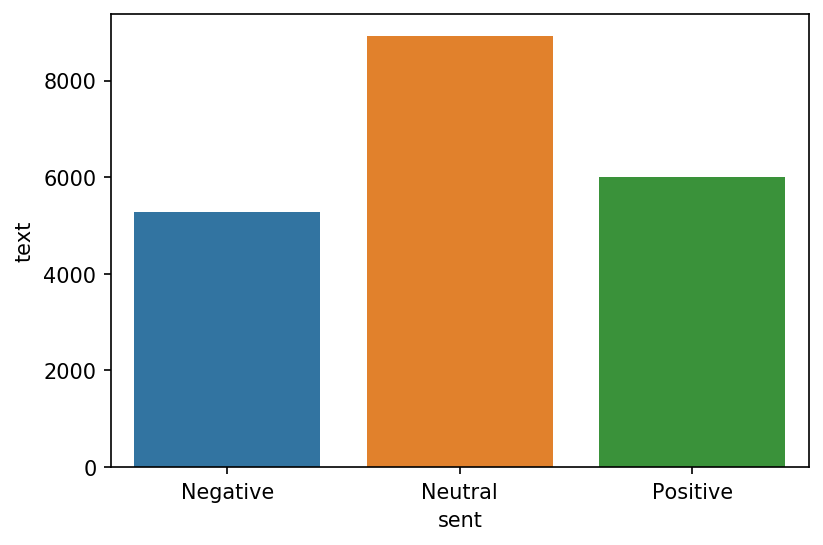

In [64]:
sns.barplot(x='sent', y='text', data=data_explore_grp.reset_index())

## Data Preprocessing 
<hr>

### Clean Reviews
* Remove stopwords and punctuation
* Set to lowercase
* Tokenize each sentence

### Categorize Labels 

* __Positive__ = 3
* __Negative__ = 1
* __Neutral__ = 2

### Build Emoji Sentiment Class

Scrape the web for emoji sentiment based on the following paper and site:

http://kt.ijs.si/data/Emoji_sentiment_ranking/index.html

* P. Kralj Novak, J. Smailovic, B. Sluban, I. Mozetic,<br>
__Sentiment of Emojis__, PLoS ONE 10(12): e0144296, doi:10.1371/journal.pone.0144296, 2015.


#### Emoji Confidence Feature

Feature Creation which attempts to sift through the Pos, Neg, Neut scores and determine which it decidedly favors within the three. Filters prior to 

#### f(x) = $\frac{(x - mu)^2}{sigma}$

* X (here being one of the Pos, Neg, Neut) is filtered if the value isn't greater than .15 and given a zero. 
* The deviation has to be greater than .2 from the mean to reject the null that x != x_bar


In [65]:
try:
  from emoji import UNICODE_EMOJI
except:
  !pip install emoji
  from emoji import UNICODE_EMOJI
from bs4 import BeautifulSoup
import requests as r

class EmojiSent():
    
    def __init__(self, text): 
        
        # URL param to get emoji sentiment scores
        self.url = r'http://kt.ijs.si/data/Emoji_sentiment_ranking/index.html'
        # pandas series of text
        self.text = text
        # Fetch the Emoji Sentiment Scores
        self._get_emoji_sent()
        
    def _get_emoji_sent(self) -> pd.DataFrame:

        print('\nGetting Emoji Sentiment Scores\n')
        html = r.get(self.url).content
        soup = BeautifulSoup(html, 'lxml')

        table = soup.find_all('table')[0]
        self.sentFrame = pd.read_html(str(table))[0]

        # CleanUp the columns
        self.sentFrame.columns = ['Char','image','Unicodepoint','Occurences','Position','Neg',
                             'Neut','Pos', 'Emoji_SentScore', '_', 'UnicodeName', 'UnicodeBlock']

        return self.sentFrame


    def text_has_emoji(self, text) -> bool:
        for character in text:
            if character in UNICODE_EMOJI:
                return True
        return False
    
    def build_sentiment_frame(self) -> pd.DataFrame:
        
        self._find_emojis()
        
        print('\nBuilding Emoji Sentiment DataFrame\n')
        self.emoji_sent = self.emoji_match.reset_index()\
        .merge(self.sentFrame, left_on='emoji_match', right_on='Char')\
        .loc[:,['index','Char', 'Position','Neg', 'Neut', 'Pos', 'Emoji_SentScore']]
        
        # Multiple Emojis to one index 
        # Decided to take the mean of Sentiment within the text
        self.emoji_sent = self.emoji_sent.groupby('index').mean()
        
        self.text_sentiment = self.emoji_sent.merge(self.text, left_index=True, right_index=True)
        self.text_sentiment['emoji_conf'] = self.text_sentiment.loc[:, ['Neg','Neut','Pos']]\
                                                               .apply(lambda x: self.emoji_confidence(x), axis=1)
        
        return self.text_sentiment
    
    
    def emoji_confidence(self, data) -> int:
        
        result =  pd.Series([y if y > .2 else np.nan\
                       for y in [np.round((x - np.mean(data))**2 / np.std(data), 3) \
                                 if x > .15 else 0 for x in data]]
                     ).argmax()
        
        if result < 0:
            return np.nan
        
        return result + 1

    
    def _find_emojis(self) -> None:
        
        print(f'\nFinding Emojis in Text...\n{self.text.head()}')
        text_mask = self.text.apply(self.text_has_emoji)
        self.text = self.text[text_mask == True]
        
        self.emoji_match = pd.DataFrame()
        for emoji in tqdm(UNICODE_EMOJI, unit=" emojis"):
            try:
                if any(self.text[self.text.str.contains(emoji) == True]):
                    temp = self.text[self.text.str.contains(emoji) == True]
                    self.emoji_match = pd.concat([self.emoji_match, pd.Series(emoji, index=temp.index)])
                else:
                    continue

            # Some Emojis aren't separated in Text and throws an error
            except Exception as e:
                pass

        self.emoji_match.columns = ['emoji_match']
        self.emoji_match.sort_index(inplace=True)

In [66]:
def get_default_learnFrame(df):
    
    # Convert to a learnFrame from original df, perserve df
    learnFrame = df
    
    # Clean Reviews
    reviews = cleanReviews(learnFrame['text'], stop=True)
    learnFrame = pd.merge(learnFrame, pd.Series(reviews, name='tokenized_text'), left_index=True, right_index=True)
    revFrame = pd.DataFrame([(' '.join(x)) for x in reviews], columns=['cleanReviews'])
    learnFrame = pd.concat([learnFrame, revFrame], axis=1)
    
    # Encode Labels
    y = df['sent'].values
    targetEncoder = LabelEncoder()
    y = targetEncoder.fit_transform(y)
    
    
    learnFrame['sent'] =  y
    # Add 1 to prevent 0 as a label
    learnFrame['sent'] = learnFrame['sent'] + 1
    
    
    # Fetch emoji sentiment and confidence
    emo = EmojiSent(learnFrame.text).build_sentiment_frame()
    
    # Merge and tidy
    learnFrame = pd.merge(learnFrame, emo, left_index=True, right_index=True, how='outer').drop(['text_y'], axis=1)
    learnFrame.rename(columns={'text_x' : 'text'}, inplace=True)

    return learnFrame
    

def cleanReviews(texts, stop=None) -> list:
    """ Takes in a pd.Series of Reviews """
    # Stopwords courtesy and acredited to :
    # Owais Raza 
    # https://medium.com/analytics-vidhya/sentiment-analysis-on-roman-urdu-using-python-sklearn-and-nltk-c3a279ef7748
    
    stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 
           'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 'hota', 'ho', 'ga', 'ka', 
           'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 
           'gaya', 'kch', 'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to', 
           'is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala', 'waisay',
           'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski',
           'ne', 'haan', 'acha', 'nai', 'sent', 'photo', 'you', 'kafi', 'gai', 
           'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 
           'wohi', 'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna',
           'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil', 'tu', 'hum', 'par',
           'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou']
    
    tokenizer = RegexpTokenizer(r'(?:^|(?<= ))[a-zA-Z]+(?= |$)')
    reviews = []
    for count, descrip in enumerate(texts.values):
        try:
            # lower
            raw = descrip.lower()

            # token words
            tokens = tokenizer.tokenize(raw)

            # remove stopwords
            if stop:
                tokens = [i for i in tokens if not i in stopwords]

            reviews.append(tokens)
            
        except AttributeError as a:
            continue

    return reviews


learnFrame = get_default_learnFrame(df)
learnFrame.head()


Getting Emoji Sentiment Scores



  0%|                                                                                    | 0/2811 [00:00<?, ? emojis/s]


Finding Emojis in Text...
0    Sai kha ya her kisi kay bus ki bat nhi hai lak...
1                                            sahi bt h
2                                          Kya bt hai,
3                                           Wah je wah
4                                 Are wha kaya bat hai
Name: text, dtype: object


100%|████████████████████████████████████████████████████████████████████████| 2811/2811 [00:04<00:00, 657.08 emojis/s]



Building Emoji Sentiment DataFrame



,text,sent,tokenized_text,cleanReviews,Position,Neg,Neut,Pos,Emoji_SentScore,emoji_conf
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,3,"[sai, kha, her, kisi, kay, bus, bat, nhi, laki...",sai kha her kisi kay bus bat nhi lakin hal kal...,NaN,NaN,NaN,NaN,NaN,NaN
1,sahi bt h,3,"[sahi, bt, h]",sahi bt h,NaN,NaN,NaN,NaN,NaN,NaN
2,"Kya bt hai,",3,[bt],bt,NaN,NaN,NaN,NaN,NaN,NaN
3,Wah je wah,3,"[wah, je, wah]",wah je wah,NaN,NaN,NaN,NaN,NaN,NaN
4,Are wha kaya bat hai,3,"[are, wha, kaya, bat]",are wha kaya bat,NaN,NaN,NaN,NaN,NaN,NaN


## WordClouds 

(-0.5, 799.5, 399.5, -0.5)

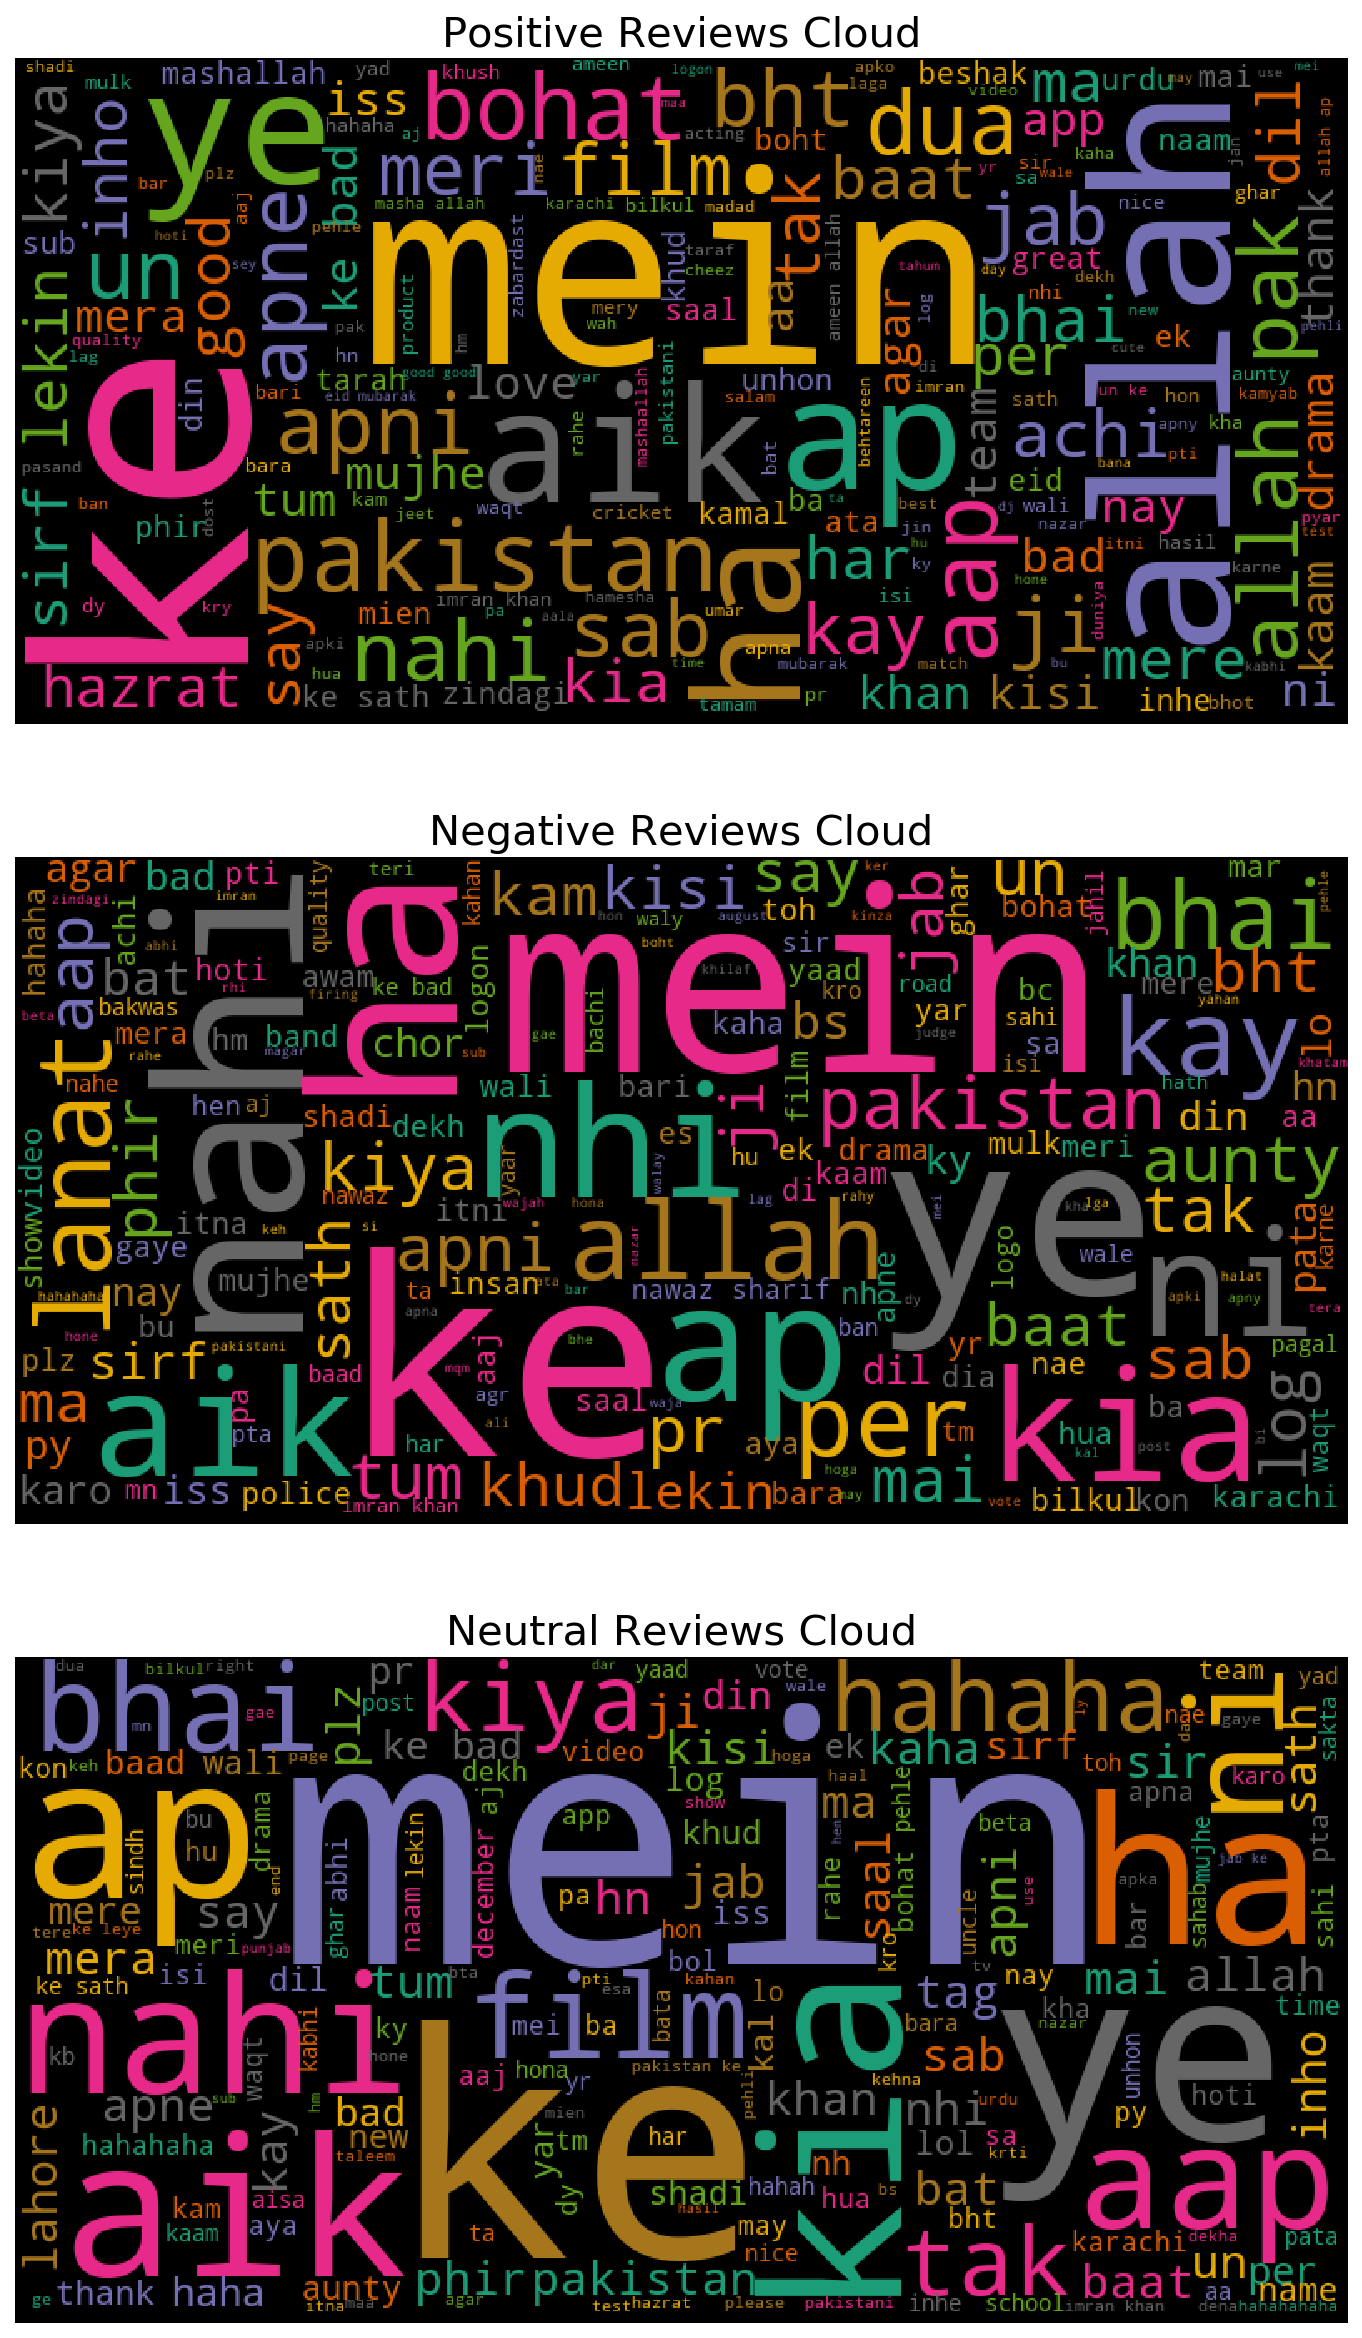

In [11]:
wc_positive = WordCloud(max_font_size=None, scale = 2, colormap = 'Dark2')\
.generate(learnFrame[learnFrame.sent == 3].cleanReviews.to_string())

wc_negative = WordCloud(max_font_size=None, scale = 2, colormap = 'Dark2')\
.generate(learnFrame[learnFrame.sent == 1].cleanReviews.to_string())

wc_neutral = WordCloud(max_font_size=None, scale = 2, colormap = 'Dark2')\
.generate(learnFrame[learnFrame.sent == 2].cleanReviews.to_string())

fig, ax = plt.subplots(3,1, figsize=(20, 20))

ax[0].imshow(wc_positive)
ax[0].set_title('Positive Reviews Cloud', fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wc_negative)
ax[1].set_title('Negative Reviews Cloud', fontsize = 20)
ax[1].axis("off")

ax[2].imshow(wc_neutral)
ax[2].set_title('Neutral Reviews Cloud', fontsize = 20)
ax[2].axis("off")

## Emoji Sentiment Distribution

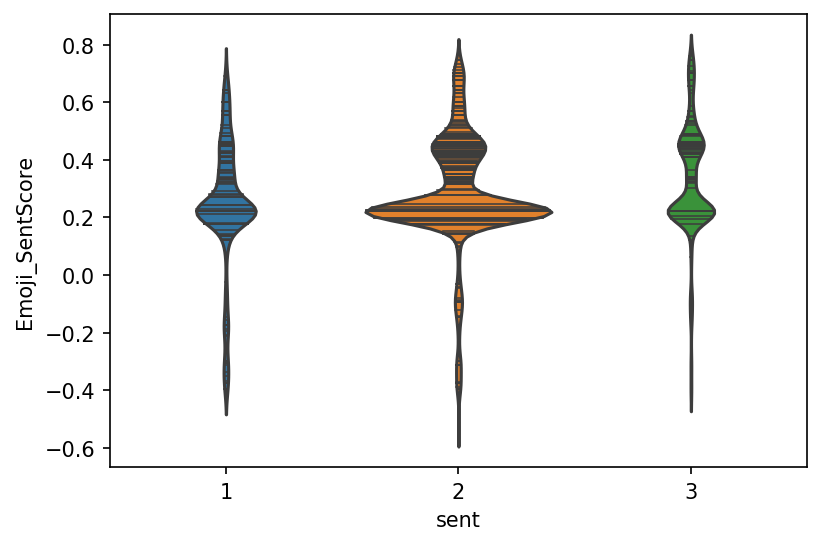

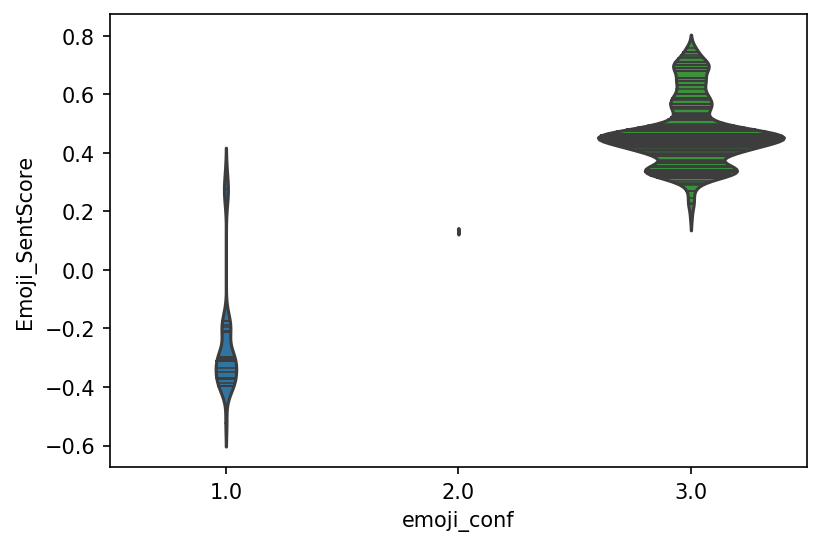

In [12]:
sns.violinplot(x='sent', y='Emoji_SentScore', scale='count', inner="stick", 
               bw=.2, data=learnFrame.dropna(thresh=1))
plt.show()
sns.violinplot(x='emoji_conf', y='Emoji_SentScore', scale='count', inner="stick", 
               bw=.2, data=learnFrame.dropna())

## Roman Urdu Embeddings - What is an Embedding ?
<hr>
<span style="color:blue; font-family:Segoe UI Semibold">
    Here we begin to explore translating the Roman Urdu Language into Vectors of numbers in the space amongst its corpus. For example in English, your knowledge of words constructed like:
    
`Football = [ 134, 234234, 143124, 14141234, 12341234, 1342424, 97965 ]`

Or we can also explore the sentence as a whole:

`['Football', 'gives', 'you', 'injuries'] = [ 623634, 532, 1346, 96873, 25345, 235, 643 ]`

## Word2Vec 

In [13]:
w2v = models.Word2Vec(learnFrame.tokenized_text, size=50, window=10, min_count=1, workers=4, seed=43, iter=5)

In [14]:
print(f'Number of reviews : {w2v.corpus_count}\nNumber of Epochs to use : {w2v.iter}')
print(f'Total Vectors : {len(w2v.wv.vectors)}')
w2v.wv.vectors[:2]

Number of reviews : 20229
Number of Epochs to use : 5
Total Vectors : 30178


array([[-3.3906116 , -0.2633093 , -0.10479632, -1.1419501 ,  1.8332269 ,
         2.2632017 , -2.3110359 , -1.7574772 , -1.2494673 , -3.5861034 ,
        -0.34723645, -0.03416329,  0.56921434,  3.5161443 , -1.4988283 ,
        -3.1086314 , -0.7776084 , -0.24252966,  3.8630521 , -2.2944524 ,
         1.3002641 , -1.721389  , -1.0445395 ,  0.47984728,  1.5395919 ,
         2.1738713 , -1.654567  ,  0.3539774 ,  0.16317977,  0.5482697 ,
        -0.61856234,  1.09092   ,  4.3027673 ,  0.21555318,  2.387462  ,
         1.2238339 ,  3.382839  , -0.06166315, -4.509912  ,  0.6291048 ,
        -1.0522218 ,  1.3090813 , -1.8018435 ,  1.335734  , -0.9736867 ,
        -0.75105715, -2.7259464 ,  0.93399626,  2.3957102 ,  0.16295753],
       [-3.3833246 , -0.41025186, -0.06328233, -1.2944686 ,  2.1875587 ,
         2.3445385 , -2.5693195 , -1.7908996 , -1.2898376 , -3.6077096 ,
        -0.2441075 ,  0.03972251,  0.59318584,  3.7673106 , -1.5575203 ,
        -3.4818735 , -0.84412014, -0.29257458,  3.

In [15]:
pd.DataFrame(w2v.wv.similar_by_word('aha'), columns=['word','similarity']).sort_values(by='similarity')

,word,similarity
9,baat,0.997390
8,director,0.997397
7,dekhte,0.997397
6,tarikh,0.997410
5,panah,0.997418
4,gher,0.997434
3,sifarish,0.997437
2,late,0.997441
1,board,0.997443
0,samne,0.997450


## Doc2Vec

My intuition is favoring to go this route over a word2vec/bag of words approach. When considering review-like collections, you really want to preserve the semantics and where words tend to fall within them.

There are two implementations:

* Paragraph Vector - Distributed Memory (PV-DM)

* Paragraph Vector - Distributed Bag of Words (PV-DBOW)

For this we choose the parameter `dm=1` for _PV-DM_

This approach attempts to predict a center word based an average of both context word-vectors and the full document’s doc-vector.

In [67]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

def build_docVecModel(learnFrame, vec_size=10):
    doc_token_text = learnFrame.tokenized_text.values
    document_for_reviews = [TaggedDocument(name, [i]) for i, name in enumerate(doc_token_text)]

    # Build Doc2Vec Model
    docVecModel = Doc2Vec(document_for_reviews, dm=1, min_count=1, vector_size=vec_size, window=10, workers=3)
    print(f'Total Words in Corpus : {docVecModel.corpus_total_words}')
    
    return docVecModel, document_for_reviews

docVecModel, document_for_reviews = build_docVecModel(learnFrame)

Total Words in Corpus : 194627


In [68]:
window = 5
doc_id = 13543

inferred_vector = docVecModel.infer_vector(document_for_reviews[doc_id].words)
sims = docVecModel.docvecs.most_similar([inferred_vector], topn=len(docVecModel.docvecs))

print(f'Model Details Params : {docVecModel}\n')
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(document_for_reviews[doc_id].words)))

topThree = [x[0] for x in sims[:window]]
bottomThree = [x[0] for x in sims[-window:]]
midpoint = len(sims)//2
neutralThree = [x[0] for x in sims[midpoint- (window - 2) : midpoint + (window-1)]]

print(f"Sentiment Label : {learnFrame.iloc[doc_id]['sent']}")
    
learnFrame[learnFrame.index.isin(topThree)]

Model Details Params : Doc2Vec(dm/m,d10,n5,w10,s0.001,t3)

Test Document (13543): «galaa nahi khrab es»

Sentiment Label : 2


,text,sent,tokenized_text,cleanReviews,Position,Neg,Neut,Pos,Emoji_SentScore,emoji_conf
2584,Is accident ke badaulat hone wali shanasaai ka...,3,"[accident, ke, badaulat, hone, wali, shanasaai...",accident ke badaulat hone wali shanasaai natij...,NaN,NaN,NaN,NaN,NaN,NaN
7075,Comedy films ke shauqeen afraad mein se shayad...,2,"[comedy, films, ke, shauqeen, afraad, mein, sh...",comedy films ke shauqeen afraad mein shayad he...,NaN,NaN,NaN,NaN,NaN,NaN
10581,Hahahaha😊😊😊😊😊,1,[],,0.813,0.06,0.237,0.704,0.644,3.0
11373,Manghopir Me CTD Ki Karwai TTP Khalid Sajna Gr...,1,"[manghopir, me, ctd, karwai, ttp, khalid, sajn...",manghopir me ctd karwai ttp khalid sajna group...,NaN,NaN,NaN,NaN,NaN,NaN
18746,Bat tu sach e.,2,"[bat, sach]",bat sach,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
def build_train_test_frame(docVecModel, learnFrame):
    
    docFrame = pd.DataFrame(docVecModel.docvecs.vectors_docs, 
                 columns = [f'docVec_{count}' for count in range(docVecModel.vector_size)])
    learnDocFrame = pd.merge(learnFrame, docFrame, right_index=True, left_index=True)
    learnDocFrame = learnDocFrame.loc[:, lambda df: (df.dtypes == np.float32) | \
                                      (df.dtypes == np.float64) | (df.dtypes == np.int32)]

    # One Hot Emoji Confidence
    oneHotFrame = pd.get_dummies(learnDocFrame.emoji_conf.dropna().astype(int))
    oneHotFrame.columns = ['emoji_conf_neg','emoji_conf_neut','emoji_conf_pos']

    # Merge up with Doc2Vec Embeddings
    learnDocFrame = pd.merge(learnDocFrame, oneHotFrame, left_index=True, right_index=True, how='outer')\
    .drop(['emoji_conf'], axis=1)

    # Divide up the data 10% Final out-of-sample Testing
    testFrame = learnDocFrame.sample(frac=.1, random_state=43)
    trainFrame = learnDocFrame.loc[~learnDocFrame.index.isin(testFrame.index)]

    return trainFrame, testFrame

trainFrame, testFrame = build_train_test_frame(docVecModel, learnFrame)
trainFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18206 entries, 0 to 20228
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sent             18206 non-null  int32  
 1   Position         1001 non-null   float64
 2   Neg              1001 non-null   float64
 3   Neut             1001 non-null   float64
 4   Pos              1001 non-null   float64
 5   Emoji_SentScore  1001 non-null   float64
 6   docVec_0         18206 non-null  float32
 7   docVec_1         18206 non-null  float32
 8   docVec_2         18206 non-null  float32
 9   docVec_3         18206 non-null  float32
 10  docVec_4         18206 non-null  float32
 11  docVec_5         18206 non-null  float32
 12  docVec_6         18206 non-null  float32
 13  docVec_7         18206 non-null  float32
 14  docVec_8         18206 non-null  float32
 15  docVec_9         18206 non-null  float32
 16  emoji_conf_neg   414 non-null    float64
 17  emoji_conf_n

## Construct Classifiers

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score

# list of (estimator, param_grid), where param_grid is used in GridSearchCV
classifiers = [
    (GaussianNB(), {
    }),
    (LogisticRegression(random_state=43), {
        'C': [int(x) for x in np.round(np.logspace(1, 2, 5), 0).tolist()]
    }),
    (LinearSVC(random_state=43), {
        'C': [int(x) for x in np.round(np.logspace(1, 2, 5), 0).tolist()]
    }),
    (GradientBoostingClassifier(n_estimators=50, random_state=43), {
        'learning_rate': np.round(np.logspace(-4, 1, 5), 4)
    }),
    (SVC(random_state=43), {
        'C': [int(x) for x in np.round(np.logspace(1, 2, 5), 0).tolist()]
    }),
    (RandomForestClassifier(random_state=43), {
        'max_depth' : [2, 6, 10], 
        'n_estimators' : [int(x) for x in np.round(np.logspace(1, 2, 5), 0).tolist()]
    })
]

## Training Classifiers and Predict

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


def train_classifiers(trainFrame, strat=False) -> dict:
    
    X = trainFrame.loc[:, 'Position':].dropna().values
    y = trainFrame.dropna()['sent'].values

    # Standardize - mean = 0, std = 1
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.2, 
                                                        random_state=43)
    # 80/20 training/testing
    if not strat:
        clfs = {}
        names = [ e.__class__.__name__ for e, g in classifiers]

        # Run thru the classifiers
        for name, (estimator, param_grid) in tqdm(zip(names, classifiers), unit='clf'):

            print(name)
            clf = GridSearchCV(estimator=estimator, param_grid=param_grid)
            print(f"HyperParams: {param_grid}")
            with ignore_warnings(category=ConvergenceWarning):
                clf.fit(X_train, y_train)
                
            y_pred = clf.predict(X_test)
            
            precision = precision_score(y_test, y_pred, average=None)
            score = accuracy_score(y_test, y_pred)
            conf_mat = multilabel_confusion_matrix(y_test, y_pred)
            
            clfs[f'{name}'] = {'Classifier' : clf,
                               'Accuracy' : score, 
                               'Precision' : precision, 
                               'ConfMatrix' : conf_mat}
        return clfs
    
    # Stratified training/testing
    else:
        splitter = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=43)
        print(f'Number of Splits : {splitter.n_splits}')

        clfs = {}

        names = [ e.__class__.__name__ for e, g in classifiers]

        # Run thru the classifiers
        for est_idx, (name, (estimator, param_grid)) in \
                tqdm(enumerate(zip(names, classifiers))):

            clf = GridSearchCV(estimator=estimator, param_grid=param_grid)

            for count, (train_index, test_index) in enumerate(splitter.split(X,  y), 1):
                print("TRAIN:", train_index, "TEST:", test_index)
                
                X_train, X_test = StandardScaler().fit_transform(X[train_index]),
                StandardScaler().fit_transform(X[test_index])
                
                y_train, y_test = y[train_index], y[test_index]

                with ignore_warnings(category=ConvergenceWarning):
                    clf.fit(X_train, y_train)

                y_pred = clf.predict(X_test)
                precision = precision_score(y_pred, y_test, average=None)
                score = accuracy_score(y_test, y_pred)
                conf_mat = multilabel_confusion_matrix(y_test, y_pred)
                clfs[f'{name}_{count}_{est_idx}'] = {'Classifier' : clf,
                                                     'Accuracy' : score, 
                                                     'Precision' : precision, 
                                                     'ConfMatrix' : conf_mat}
        return clfs

In [53]:
def model_metrics(clfs):
    
    labels=['Neutral','Negative','Positive']
    
    for k in clfs.keys():
        print(f"\n{k} Accuracy : {clfs[k]['Accuracy']}")
        for count, sent in enumerate(labels):
            classifier = k
            
            print(f"\nConfMatrix {sent} :\n{classifier}")
    
            try:

                fig = plt.figure(figsize= (2,2))
                ax = fig.add_subplot(111)
                cax = ax.matshow(clfs[k]['ConfMatrix'][count])
                plt.title(f'Confusion matrix of {classifier} : {labels[count]}\n')
                fig.colorbar(cax)
                ax.set_xticklabels([''] + ['Positive' , 'Negative'])
                ax.set_yticklabels(['']+ ['Positive' , 'Negative'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

            except Exception as e:
                print(f"Didn't get a plot : {str(e)}")
        
   

0clf [00:00, ?clf/s]

GaussianNB
HyperParams: {}
LogisticRegression
HyperParams: {'C': [10, 18, 32, 56, 100]}


2clf [00:00,  2.81clf/s]

LinearSVC
HyperParams: {'C': [10, 18, 32, 56, 100]}


3clf [00:02,  1.27clf/s]

GradientBoostingClassifier
HyperParams: {'learning_rate': array([1.000e-04, 1.800e-03, 3.160e-02, 5.623e-01, 1.000e+01])}


4clf [00:09,  2.55s/clf]

SVC
HyperParams: {'C': [10, 18, 32, 56, 100]}


5clf [00:09,  1.89s/clf]

RandomForestClassifier
HyperParams: {'max_depth': [2, 6, 10], 'n_estimators': [10, 18, 32, 56, 100]}


6clf [00:15,  2.56s/clf]



GaussianNB Accuracy : 0.3253012048192771

ConfMatrix Neutral :
GaussianNB


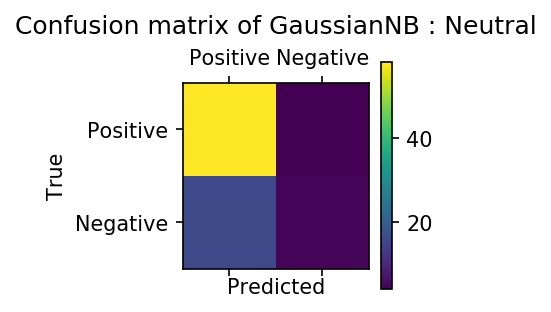


ConfMatrix Negative :
GaussianNB


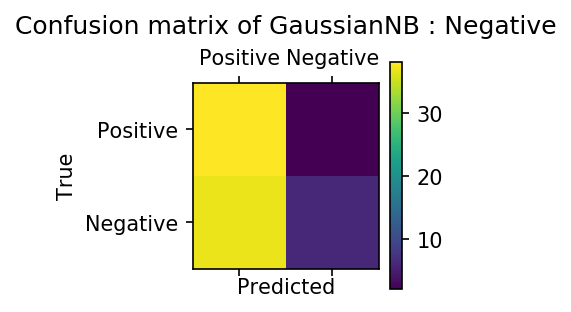


ConfMatrix Positive :
GaussianNB


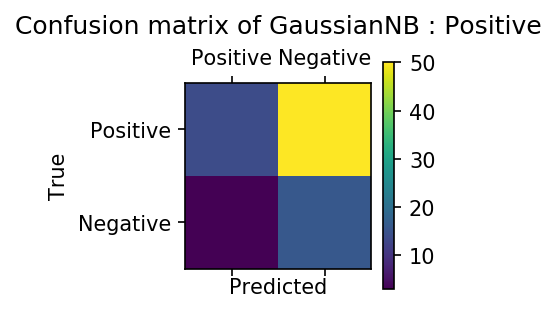


LogisticRegression Accuracy : 0.5542168674698795

ConfMatrix Neutral :
LogisticRegression


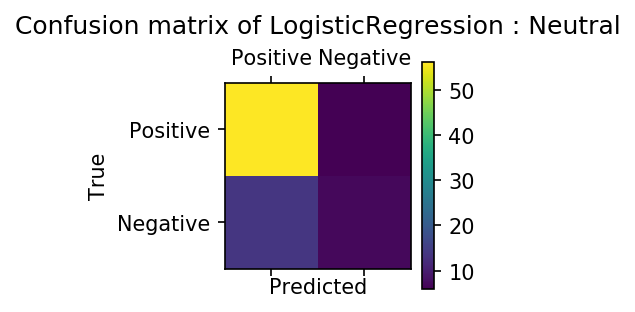


ConfMatrix Negative :
LogisticRegression


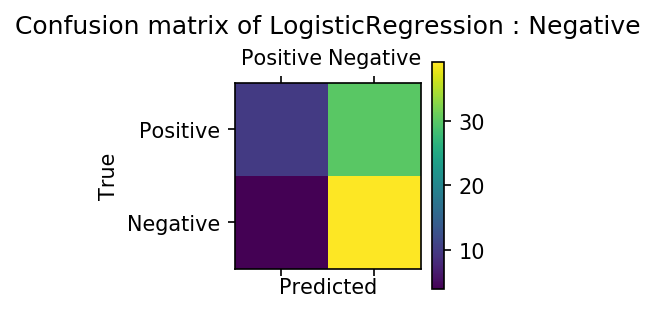


ConfMatrix Positive :
LogisticRegression


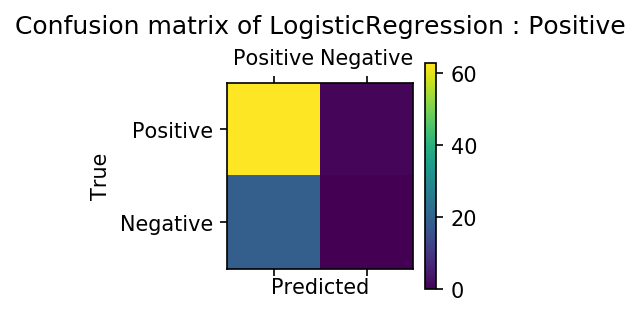


LinearSVC Accuracy : 0.4939759036144578

ConfMatrix Neutral :
LinearSVC


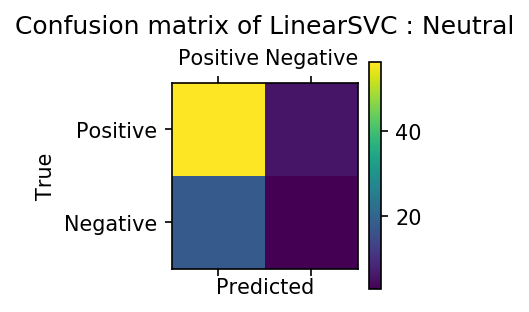


ConfMatrix Negative :
LinearSVC


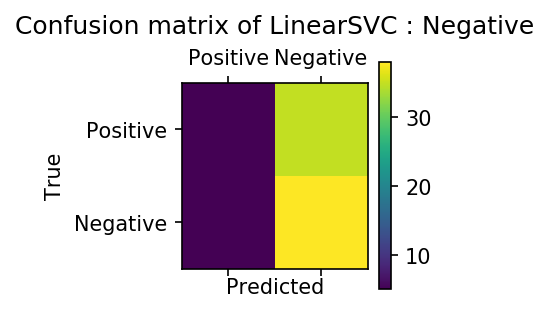


ConfMatrix Positive :
LinearSVC


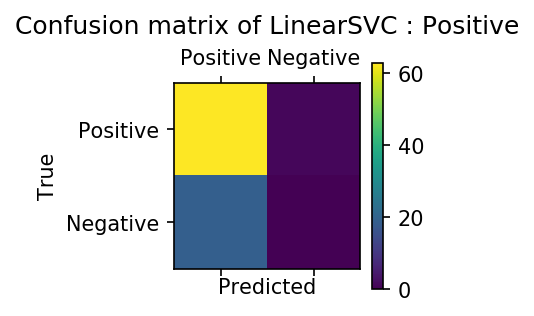


GradientBoostingClassifier Accuracy : 0.5180722891566265

ConfMatrix Neutral :
GradientBoostingClassifier


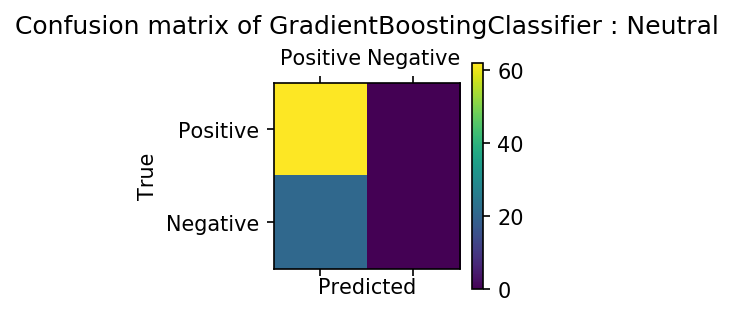


ConfMatrix Negative :
GradientBoostingClassifier


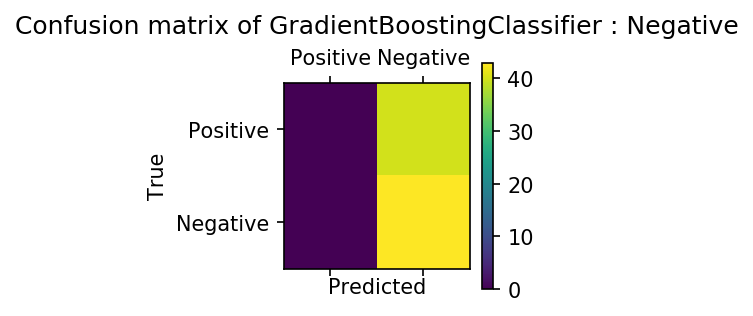


ConfMatrix Positive :
GradientBoostingClassifier


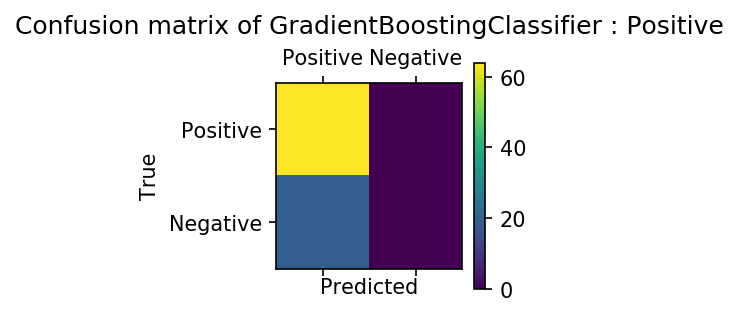


SVC Accuracy : 0.5060240963855421

ConfMatrix Neutral :
SVC


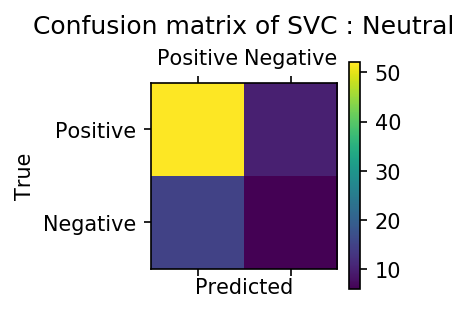


ConfMatrix Negative :
SVC


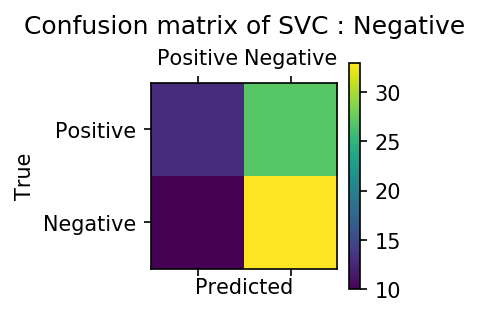


ConfMatrix Positive :
SVC


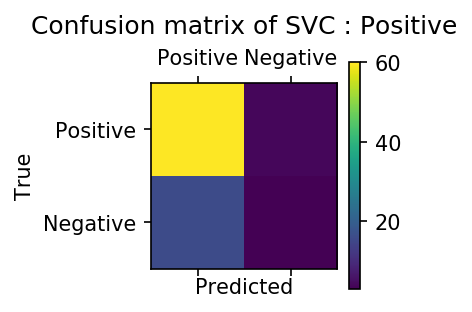


RandomForestClassifier Accuracy : 0.5180722891566265

ConfMatrix Neutral :
RandomForestClassifier


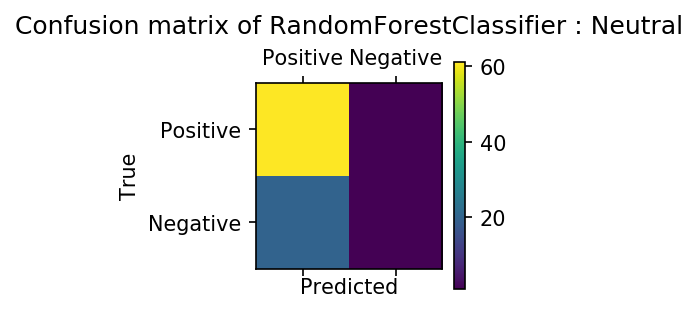


ConfMatrix Negative :
RandomForestClassifier


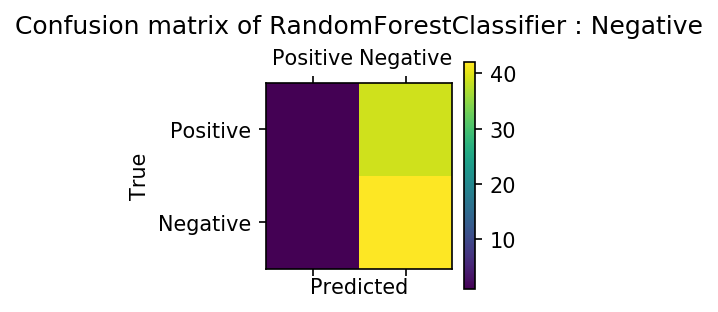


ConfMatrix Positive :
RandomForestClassifier


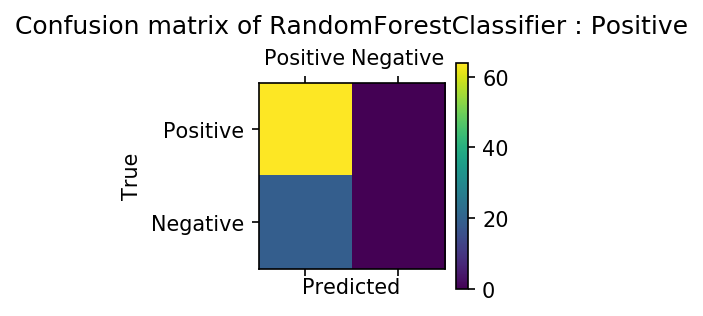

In [54]:
clfs = train_classifiers(trainFrame)
model_metrics(clfs)

## Out-of-Sample Testing

In [55]:
for k, v in clfs.items():
    print(f"{k} : {np.round(clfs[k]['Accuracy'], 2)}\nPrecision : {clfs[k]['Precision']}")

GaussianNB : 0.33
Precision : [0.55555556 0.75       0.24242424]
LogisticRegression : 0.55
Precision : [0.53846154 0.56521739 0.        ]
LinearSVC : 0.49
Precision : [0.33333333 0.52054795 0.        ]
GradientBoostingClassifier : 0.52
Precision : [0.         0.51807229 0.        ]
SVC : 0.51
Precision : [0.375      0.55       0.42857143]
RandomForestClassifier : 0.52
Precision : [0.5        0.51851852 0.        ]


In [56]:
# Test on out of sample data
X_Final = X = StandardScaler().fit_transform(testFrame.loc[:, 'Position':].dropna().values)
y_Final = testFrame.dropna().loc[:,['sent']].values


clf = clfs['LogisticRegression']['Classifier']
pred = clf.predict(X_Final)
actual = y_Final

conf_mat_Final = multilabel_confusion_matrix(pred, actual)
precision = precision_score(actual, pred, average=None)
acc = accuracy_score(actual, pred)
print(f'Final Test :\n {conf_mat_Final}\n')
print(f'Accuracy : {acc}')
print(f'Precision score : Negative : {precision[0]}, Neutral : {precision[1]}, Positive : {precision[2]}')

print(f'Predictions: {pred}')

Final Test :
 [[[29  8]
  [ 2  2]]

 [[ 3  2]
  [13 23]]

 [[34  6]
  [ 1  0]]]

Accuracy : 0.6097560975609756
Precision score : Negative : 0.5, Neutral : 0.6388888888888888, Positive : 0.0
Predictions: [2 2 2 1 2 2 3 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 1]


In [49]:
# Test on out of sample data
X_Final = X = StandardScaler().fit_transform(testFrame.loc[:, 'Position':].dropna().values)
y_Final = testFrame.dropna().loc[:,['sent']].values


clf = clfs['GaussianNB']['Classifier']
pred = clf.predict(X_Final)
actual = y_Final

conf_mat_Final = multilabel_confusion_matrix(pred, actual)
precision = precision_score(actual, pred, average=None)
acc = accuracy_score(actual, pred)
print(f'Final Test :\n {conf_mat_Final}\n')
print(f'Accuracy : {acc}')
print(f'Precision score : Negative : {precision[0]}, Nuetral : {precision[1]}, Positive : {precision[2]}')

print(f'Predictions: {pred}')

Final Test :
 [[[ 0  0]
  [31 10]]

 [[16 25]
  [ 0  0]]

 [[35  6]
  [ 0  0]]]

Accuracy : 0.24390243902439024
Precision score : Negative : 0.24390243902439024, Nuetral : 0.0, Positive : 0.0
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [50]:
pd.DataFrame([pred, actual]).T

,0,1
0,1,[2]
1,1,[2]
2,1,[2]
3,1,[1]
4,1,[2]
5,1,[3]
6,1,[2]
7,1,[3]
8,1,[2]
9,1,[2]


## Neural Network - Embeddings, CNN, Pooling, and LSTM

In [78]:
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,  Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, LSTM, MaxPooling1D
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


# Retrain Doc2Vec model with a wider vector space
# docVecModel_new = build_docVecModel(learnFrame, vec_size=80)
# trainFrame, testFrame = build_train_test_frame(docVecModel_new, learnFrame)

dictionary = corpora.Dictionary(learnFrame.tokenized_text)
idx_seq = [dictionary.doc2idx(word) for word in learnFrame.tokenized_text]

# set parameters:
max_features = len(dictionary.cfs.keys())+1
maxlen = max(len(x) for x in idx_seq )

batch_size = 50
hidden_dims = 250
epochs = 7

# Embedding
embedding_dims = 500

# Convolution
filters = 250
kernel_size = 3

# Pooling Features
pool_size = 2

# LSTM 
lstm_output_size = 240

# Recap Layer
hidden_dims = 240

# Training
batch_size = 32
epochs = 7

# Embedding Index Sequences
y = learnFrame.loc[:,['sent']].values
X = idx_seq
print(f'Targets: {np.unique(y)}')

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=43)

# Arrange for categorical crossentropy 
# probabilities for multiple classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


print('Pad sequences (samples x times)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))


# Start to Feed the Network with our data
# Trying to filter contexts
model.add(Conv1D(
                 filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)
         )

model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.3))
model.add(LSTM(lstm_output_size))
model.add(Dropout(0.3))

model.add(Dense(hidden_dims, kernel_regularizer=l2(.01)))
model.add(Activation('relu'))


model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

print('Train...')
print(model.summary())
hist1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test), verbose=1)

Targets: [1 2 3]
16183 train sequences
4046 test sequences
Pad sequences (samples x times)
x_train shape: (16183, 190)
x_test shape: (4046, 190)
Build model...
Train...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 190, 500)          15089500  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 188, 250)          375250    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 94, 250)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 94, 250)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 240)               471360    
_________________________________________________________________
dropout_12 (Dropo

KeyboardInterrupt: 

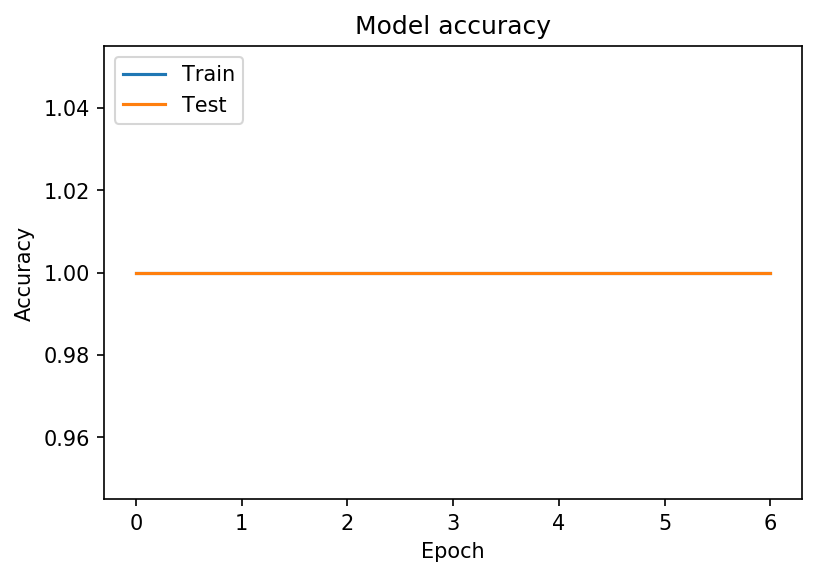

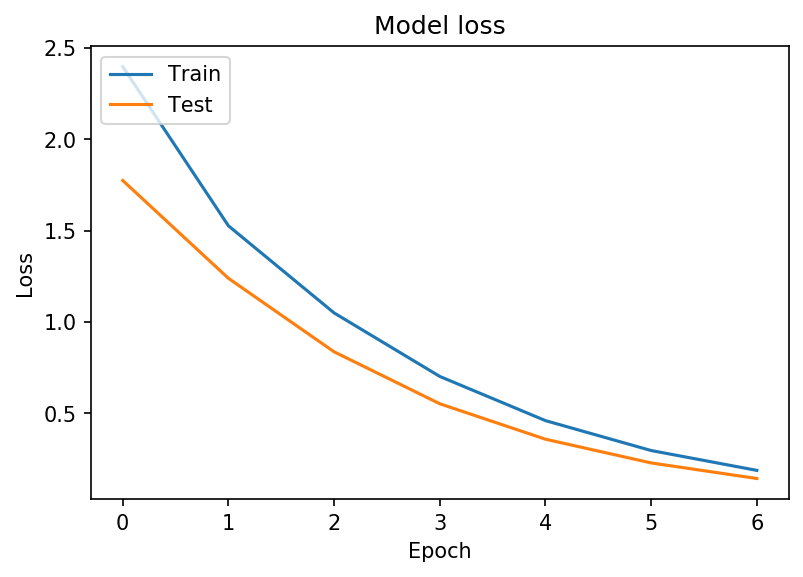

In [76]:
def plot_model(hist):

    # Plot training & validation accuracy values
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
plot_model(hist1)

In [33]:
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import to_categorical

testFrame = learnFrame.sample(frac=.1, random_state=43)
trainFrame = learnFrame.loc[~learnFrame.index.isin(testFrame.index)]

dictionary = corpora.Dictionary(learnFrame.tokenized_text)
idx_seq = [dictionary.doc2idx(word) for word in learnFrame.tokenized_text]


# set parameters:
max_features = len(dictionary.cfs.keys())+1
maxlen = max(len(x) for x in idx_seq )
batch_size = 300
embedding_dims = 500
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 7

y = learnFrame.loc[:,['sent']].values
X = idx_seq
print(f'Targets: {np.unique(y)}')

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=43)

# Arrange for categorical crossentropy 
# probabilities for multiple classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


print('Pad sequences (samples x times)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.3))

# we add a Convolution1D, which will learn filters
# word group filters of size kernel_size
# scan 1 letter at a time
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling, want to look at the Convolution features
# and then summarize them up and take the Max Feature that pops
model.add(GlobalMaxPooling1D())

# Adding another hidden layer to learn weighting of the Max Features:
model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

# Connect to 4 targets output layer
# activate with softmax:
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

print(model.summary())
hist2 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test), verbose=1)

Targets: [1 2 3]
16183 train sequences
4046 test sequences
Pad sequences (samples x times)
x_train shape: (16183, 190)
x_test shape: (4046, 190)
Build model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 190, 500)          15089500  
_________________________________________________________________
dropout_3 (Dropout)          (None, 190, 500)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 188, 250)          375250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)       

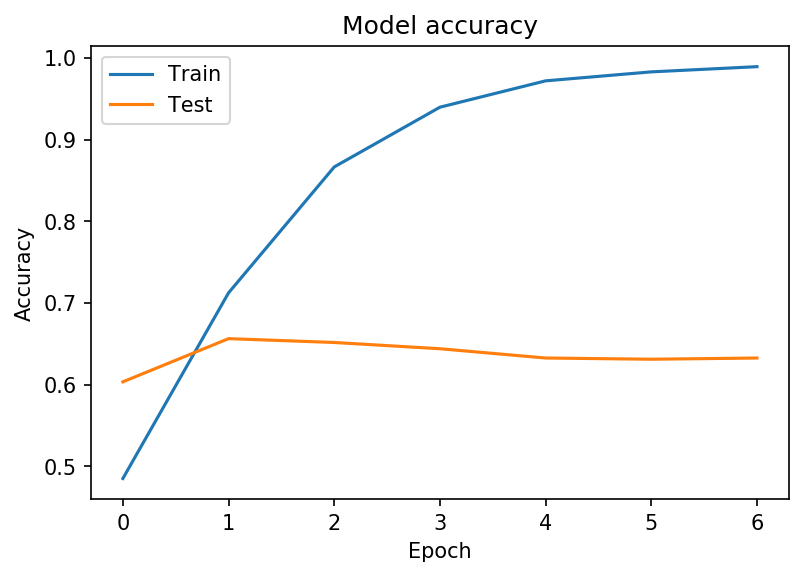

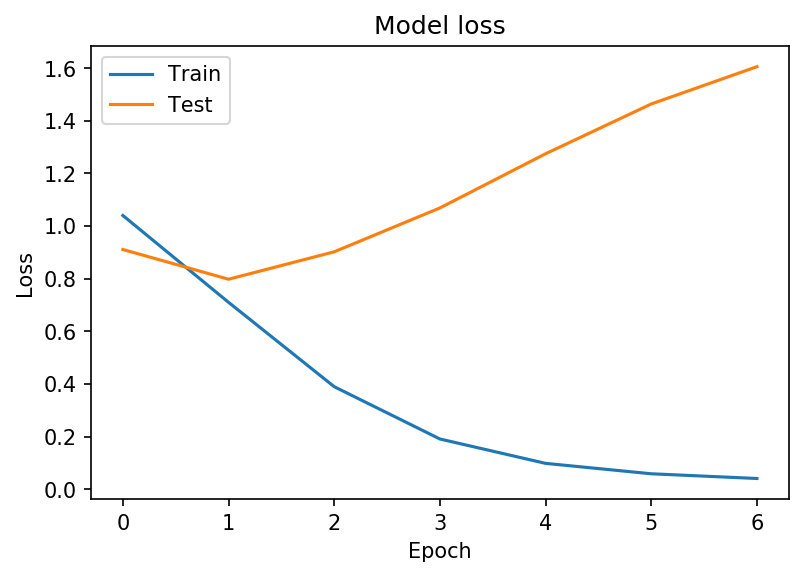

In [34]:
plot_model(hist2)

## Custom Neural Lemmatization Build

Erick Fonseca, <b>State-of-the-art Multilingual Lemmatization</b>, Mar 11, 2019,<br>
https://towardsdatascience.com/state-of-the-art-multilingual-lemmatization-f303e8ff1a8

Business case to undergo a build that aims to aid in the standardization of Roman Urdu with machine learning resulting in lemmetizing the language.

In [35]:
try:
    import spacy
    import xx_ent_wiki_sm
    nlp = xx_ent_wiki_sm.load()

except:
    !pip install spacy
    # To DL multilanguage set: 
    !python -m spacy download xx_ent_wiki_sm --user
    import xx_ent_wiki_sm
    nlp = xx_ent_wiki_sm.load()
    
from collections import Counter
import string
from pprint import pprint

# Remove pesky punctuation and smart quotes
doc = learnFrame.text.iloc[50:60].str.replace('[^\w\s]', '').apply(nlp)

pprint(doc.apply(lambda x: ([(X.text, X.label_) for X in x.ents])))

# for sent in doc:
#     print(spacy.displacy.render(nlp(str(sent)), jupyter=True, style='ent'))

50    [(Rehmat Gramophone House, MISC), (Udhar Zinda...
51                                   [(Niazi ki, MISC)]
52                                    [(Lekin us, ORG)]
53                                [(Radio aur TV, ORG)]
54           [(Lekin, PER), (Attaullah Esakhelvi, PER)]
55    [(Attaullah Esakhelvi, PER), (Mianwali, LOC), ...
56    [(Mianwali, LOC), (Attaullah Esakhelvi, PER), ...
57    [(Phir, PER), (Pakistan, LOC), (Attaullah Esak...
58    [(Attaullah Esakhelvi, PER), (Attaullah Esakhe...
59                         [(Attaullah Esakhelvi, PER)]
Name: text, dtype: object


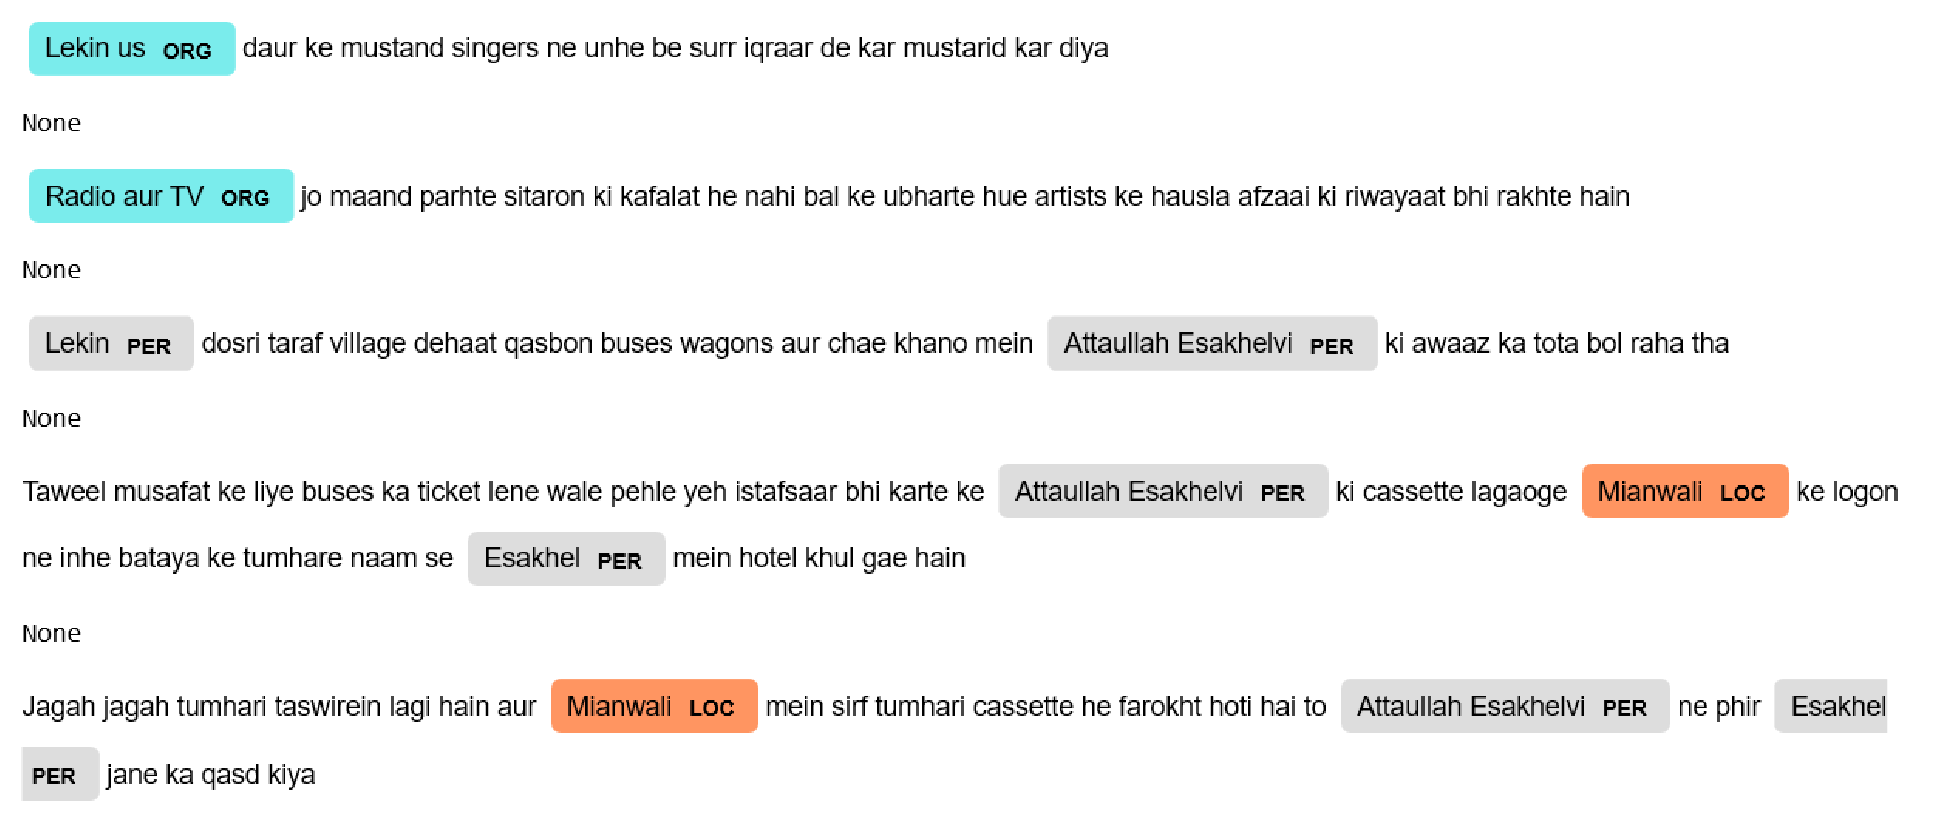

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(17,7))
img=mpimg.imread("./AmazonTechnicalTest1/spacyPic.png")
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Conclusion 

### Situation 

The Roman Urdu data set is a challenging one which exposes a lot of data scientist on some luxuries we have from prior research. Reading through all the papers, you can see the frustrations and yearn for standardization which is pretty messy and unorganized. 

But not all was lost being that I was able to locate Roman Urdu stopwords and clean the text for words only. This allowed me to explore and cut a path that could lead to some results for classifying sentiment correctly.

### Tasks <br>

#### Emoji Sentiment<br>

_A picture is worth a thousand words_ so I wanted to explore emojis and see if there was anything to derive from them. I needed a way to score and also attribute how much of the emoji swayed the classification. 

#### NLP Techniques<br>

I needed to build a usable corpus that could produce usable embeddings. Gensim and Keras were used to explore embeddings and ensemble combinations to feed classifiers.

* Gensim - Word2Vec - Word Embeddings that consisted of the Reviews
* Gensim - Doc2Vec - Reviews as a whole Document Embeddings
* Keras API - Deep Learning - Text Sentiment
* SpaCy - POS - Point of Speech

#### Classifiers 

```
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
```
Conduct a GridSearch through them all and explore a range of parameters of Cost and Learning Rate depending on the model.


### Actions 

I discovered an emoji data set that I was able to leverage and build sentiment with. These were transformed to explore how much confidence did the emojis used contribute into determination of positive, negative, or neutral. The emoji combination would attribute to a average sentiment spread across these three classes. A basic deviation from the mean between them would determine exactly which it was confident in.

Next within the analysis, I decided to pursue Doc2Vec Embeddings accompanied with Emoji Sentiment Confidence. My thought process was to capture the more "birds eye view" of the review which would preserve context and semantics, not just words for more Genearlization. I could preserve semantics and then use these embeddings with all the classifiers, in addition to feeding Neural Nets as first layers of input.

Deep learning with Roman Urdu was the next step. Keras allowed me to build the whole model top to bottom. The model architecture for the best network was as follows:<br>

* Embedding layer that injested a sequence of indexes within the corpus. I observed an decrease in val_loss expanding the deminsionality.<br>
* Drop about 20% of the neurons here for balance, preventing overfitting, and dependency. <br>
* Convolutional which allows me to scan over sentences a letter at a time extracting patterned features<br>
* MaxPooling historically is layed next summarizing these features coming from the Convolution Layer. These pooled summaries get a max feature and gives you what "pops" from all the features.<br>
* Dense Layer added after pooling to learn all these MaxPooling summary combinations and how they interact. If we went directly to an output layer here we would miss weighting attributing among these before classifying. <br>
* Finally our Output layer to settle up and make a classification utilizing a softmax activation. This activation is important here since we want our probabilities to account for the other classes. Sigmoid would range between 0 and 1 but these classes are not independent from another and have a relationship. <br>

### Results<br>

#### Doc2Vec Emoji Classification<br>

The Doc2Vec coupled with Emoji Sentiment was terrible and performed horribly. There just wasn't anything the classifiers were able to leverage their weight onto to make some definitive classifications. However, it was great and I felt like I learned quite a bit more about embeddings when trying to classify them. The vector representation of that review broken down into individual features did not offer anything no matter the hyperparamter of cost or learning-rate. This also is indicative of when attempting to feed these same embeddings into a Convolutional Layer. The granularity of word versus the review as a whole made a decidingly big difference.

I abandoned the Doc2Vec embeddings and wanted to see if the emoji sentiment data would benefit in classifying negative sentiment. This also proved somewhat trivial and would like to see more data on it.

#### Deep Learning<br>

Best Resulting Epoch:
```
Epoch 2/7
16183/16183 [==============================] - 156s 10ms/step - 
loss: 0.7100 
- categorical_accuracy: 0.7123 
- val_loss: 0.7977 
- val_categorical_accuracy: 0.6562
```

This network is easily and quick to overfit on the text which isn't a very good indication a lot of learning and knowledge is being discovered. The Lexicon codification and standardization issue with Roman Urdu I believe are being observed and show the need. I did not attempt to lemmatize the text which, if done effectively, could prove to be highly advantageous. I start to show previously with SpaCy and how you could utilize POS (Part of Speech) within comments or reviews to start to tackle Lexical Variations and ambiguity. From what I have observed on Twitter, the Roman Urdu language appears to naturally grow with irregular and morph with words as it finds its way much like American, British, and Australian language comes to being and including these irregular combinations within training will be imperative. These would be the data limitations that I would want to be addressed when considering Roman Urdu sentiment analysis within a larger project.










